In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import plotly.express as px
sns.set()

# Data Exploration

In [281]:
df = pd.read_csv('/content/kia_cars2.csv')
df.head()

,city,year,brand,model,color,body_type,engine,engine_power,fuel_type,kilometrage,transmission,drivetrain,new,price
0,Sumqayıt,2008,Kia,Ceed,Göy,Universal,1.6 L,115 a.g.,Dizel,167 055 km,Mexaniki,Ön,Xeyr,14 300 AZN
1,Bakı,2012,Kia,Sorento,Gümüşü,Offroader / SUV,2.0 L,170 a.g.,Dizel,154 000 km,Avtomat,Tam,Xeyr,32 700 AZN
2,Bakı,2015,Kia,Sorento,Ağ,Offroader / SUV,2.2 L,197 a.g.,Dizel,97 000 km,Avtomat,Tam,Xeyr,43 900 AZN
3,Sumqayıt,2008,Kia,Ceed,Gümüşü,Hetçbek / Liftbek,1.4 L,109 a.g.,Benzin,152 524 km,Mexaniki,Ön,Xeyr,13 200 AZN
4,Bakı,2013,Kia,Sorento,Ağ,Offroader / SUV,2.0 L,184 a.g.,Dizel,61 838 km,Avtomat,Tam,Xeyr,32 850 AZN


In [282]:
df.shape

(3867, 14)

# Data Cleaning

### Missing and Duplicate values

In [283]:
df.isnull().sum().sum()
# We don't have any null value

0

In [284]:
# Check for duplicates
df.duplicated().sum()

1297

In [285]:
# Remove duplicates
df = df.drop_duplicates()

### Fixing inconsistencies

In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2570 entries, 0 to 3866
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   city          2570 non-null   object
 1   year          2570 non-null   int64 
 2   brand         2570 non-null   object
 3   model         2570 non-null   object
 4   color         2570 non-null   object
 5   body_type     2570 non-null   object
 6   engine        2570 non-null   object
 7   engine_power  2570 non-null   object
 8   fuel_type     2570 non-null   object
 9   kilometrage   2570 non-null   object
 10  transmission  2570 non-null   object
 11  drivetrain    2570 non-null   object
 12  new           2570 non-null   object
 13  price         2570 non-null   object
dtypes: int64(1), object(13)
memory usage: 301.2+ KB


Let's look for inconsistencies in dataset. We can clearly see that when some columns should be numeric they are in object type. Such as `Price` , `Engine`, `Kilometrage`, `Engine_power`. Let's transform them to numeric columns first.

`Price` column

In [287]:
# Since values in price column are in different currencies. We should convert all to AZN
df['currency_price'] = df.loc[df['price']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [288]:
df['price'] = df['price'].apply(lambda x: x.replace(' ',''))
df['price'] = df['price'].apply(lambda x: x.replace('AZN', ''))
df['price'] = df['price'].apply(lambda x: x.replace('$', ''))
df['price'] = df['price'].apply(lambda x: int(x.replace('€','')))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [289]:
df.loc[df['currency_price'].str.contains('\$'), 'price'] = df['price'] * 1.7
# Right now US Dollars to Azerbaijan Manats Exchange Rate is 1.7
df.loc[df['currency_price'].str.contains('€'), 'price'] = df['price'] * 1.94
# Right now Euros to Azerbaijan Manats Exchange Rate is 1.94

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [290]:
df['price(AZN)'] = df['price']
df.drop(['currency_price', 'price'],axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**`Engine` column**

In [291]:
df['engine'].unique()

array(['1.6 L', '2.0 L', '2.2 L', '1.4 L', '2.4 L', '1.5 L', '1.1 L',
       '1.7 L', '1.8 L', '2.5 L', '3.8 L', '3.3 L', '3.0 L', '1.0 L',
       '3.5 L', '2.7 L', '1.3 L', '1.2 L', '2.8 L', '2.9 L'], dtype=object)

In [292]:
df['engine(L)'] = df['engine'].apply(lambda x: float(x.replace(' L','')))
df.drop(['engine'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



`Kilometrage` column

In [293]:
df['kilometrage'].unique()

array(['167 055 km', '154 000 km', '97 000 km', ..., '32 992 km',
       '364 518 km', '339 000 km'], dtype=object)

In [294]:
df['kilometrage'] = df['kilometrage'].apply(lambda x: x.replace(' km', ''))
df['kilometrage'] = df['kilometrage'].apply(lambda x: int(x.replace(' ', '')))

`Engine_power` column

In [295]:
df['engine_power'].unique()

array(['115 a.g.', '170 a.g.', '197 a.g.', '109 a.g.', '184 a.g.',
       '180 a.g.', '274 a.g.', '188 a.g.', '202 a.g.', '65 a.g.',
       '166 a.g.', '97 a.g.', '165 a.g.', '174 a.g.', '150 a.g.',
       '90 a.g.', '123 a.g.', '247 a.g.', '143 a.g.', '163 a.g.',
       '141 a.g.', '110 a.g.', '125 a.g.', '116 a.g.', '132 a.g.',
       '175 a.g.', '126 a.g.', '200 a.g.', '140 a.g.', '107 a.g.',
       '177 a.g.', '124 a.g.', '100 a.g.', '293 a.g.', '149 a.g.',
       '94 a.g.', '130 a.g.', '136 a.g.', '148 a.g.', '82 a.g.',
       '242 a.g.', '99 a.g.', '112 a.g.', '80 a.g.', '186 a.g.',
       '266 a.g.', '75 a.g.', '105 a.g.', '185 a.g.', '290 a.g.',
       '178 a.g.', '204 a.g.', '69 a.g.', '194 a.g.', '156 a.g.',
       '122 a.g.', '145 a.g.', '240 a.g.', '85 a.g.', '60 a.g.',
       '106 a.g.', '181 a.g.', '83 a.g.', '101 a.g.', '64 a.g.',
       '176 a.g.', '157 a.g.', '245 a.g.', '333 a.g.', '139 a.g.',
       '133 a.g.', '164 a.g.', '294 a.g.', '260 a.g.', '15 a.g.',
       '2

In [296]:
df['engine_power(hp)'] = df['engine_power'].apply(lambda x: int(x.replace(' a.g.', '')))
df.drop(['engine_power'],axis = 1, inplace = True)

In [297]:
# Now let's look at how data look like after cleaning and changes
df.head()

,city,year,brand,model,color,body_type,fuel_type,kilometrage,transmission,drivetrain,new,price(AZN),engine(L),engine_power(hp)
0,Sumqayıt,2008,Kia,Ceed,Göy,Universal,Dizel,167055,Mexaniki,Ön,Xeyr,14300.0,1.6,115
1,Bakı,2012,Kia,Sorento,Gümüşü,Offroader / SUV,Dizel,154000,Avtomat,Tam,Xeyr,32700.0,2.0,170
2,Bakı,2015,Kia,Sorento,Ağ,Offroader / SUV,Dizel,97000,Avtomat,Tam,Xeyr,43900.0,2.2,197
3,Sumqayıt,2008,Kia,Ceed,Gümüşü,Hetçbek / Liftbek,Benzin,152524,Mexaniki,Ön,Xeyr,13200.0,1.4,109
4,Bakı,2013,Kia,Sorento,Ağ,Offroader / SUV,Dizel,61838,Avtomat,Tam,Xeyr,32850.0,2.0,184


# Exploratory Analysis and Visualization

Let's analyse the numeric columns and their statistics

In [298]:
df.describe()

,year,kilometrage,price(AZN),engine(L),engine_power(hp)
count,2570.000000,2.570000e+03,2570.000000,2570.000000,2570.000000
mean,2010.442802,1.610973e+05,20328.645642,1.814008,151.392607
std,3.966583,8.665278e+04,9940.820596,0.414958,54.184692
min,1995.000000,0.000000e+00,1950.000000,1.000000,15.000000
25%,2007.000000,1.125000e+05,13000.000000,1.500000,109.000000
50%,2010.000000,1.620000e+05,17500.000000,1.800000,140.000000
75%,2013.000000,2.000000e+05,25600.000000,2.000000,184.000000
max,2022.000000,2.670000e+06,110500.000000,3.800000,370.000000


`price(AZN):` The average price for second hand Kia car in Azerbaijan is around 20 320 AZN, highest price is 110 500 AZN but also cheapest ones around 1950 AZN can be found.

`kilometrage:` The mean kilometrage for used KIA cars are 161k km and highest one is 2 mln km. There also new cars as well with 0 kilometrage.

`engine_power(hp):` The average horsepower is around 151. Most powerful car has a horsepower of 370 while the least power car has a horsepower around 15.



In [299]:
df.corr()

,year,kilometrage,price(AZN),engine(L),engine_power(hp)
year,1.000000,-0.509379,0.751983,0.213164,0.484675
kilometrage,-0.509379,1.000000,-0.423914,-0.028237,-0.231065
price(AZN),0.751983,-0.423914,1.000000,0.453639,0.584105
engine(L),0.213164,-0.028237,0.453639,1.000000,0.689972
engine_power(hp),0.484675,-0.231065,0.584105,0.689972,1.000000


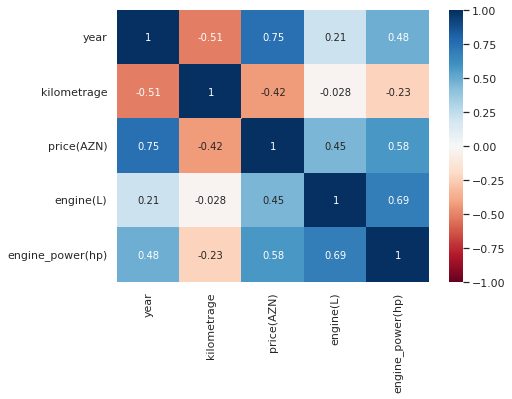

In [300]:
plt.figure(figsize = (7,5))
sns.heatmap(df.corr(), annot = True, cmap = 'RdBu', vmin = -1, vmax = 1)

#### Insights:
Price is highly (positively) correlated to the `year`, `engine(L)` and `engine_power(hp)` columns. New model cars cost high as expected
<br>
Price is negatively correlated to `kilometrage`. Means if car has been used for long time price decreases


Text(0.5, 1.0, 'Number of Cars Per Model')

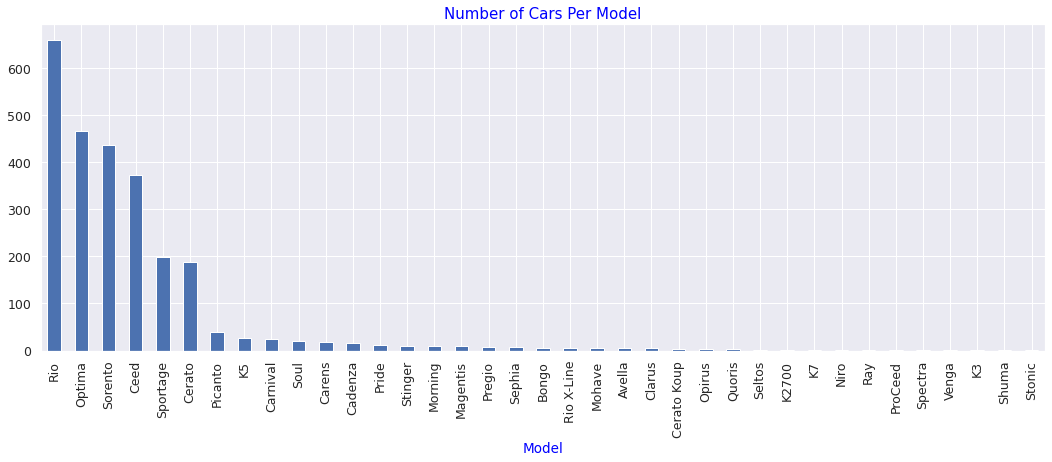

In [301]:
# Firstly, let's look at number of cars per model 
df['model'].value_counts().plot(kind = 'bar', figsize = (18,6),fontsize = 12.5)
plt.xlabel('Model',fontsize = 13.5,color = 'blue')
plt.title('Number of Cars Per Model',fontsize=15, color = 'blue')

 Most of the car models for sale are `Rio`, `Optima`, `Sorento`, `Ceed` and `Sportage` 

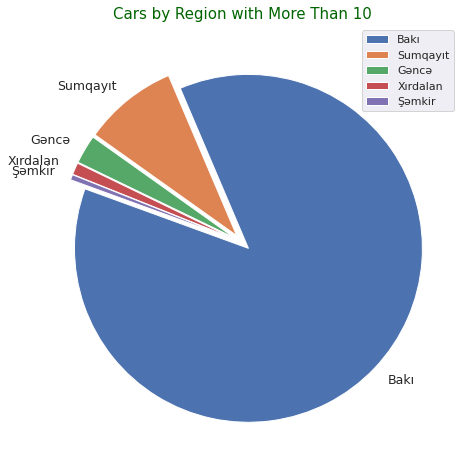

In [302]:
regions = df['city'].value_counts()
more_cars_regions = regions[regions > 10]
more_cars_regions.plot(kind = 'pie', figsize = (8,8),fontsize = 12.5, 
                                     explode = (0.05, 0.05,0.05, 0.05,0.05), 
                                     ylabel = '', 
                                     legend=True, 
                                     startangle= 160)
plt.title('Cars by Region with More Than 10',fontsize=15, color = '#006400')
plt.savefig('regions')

Regions with most of the cars are `Bakı`, `Sumqayıt`, `Gəncə`, `Xırdalan`and `Şəmkir`

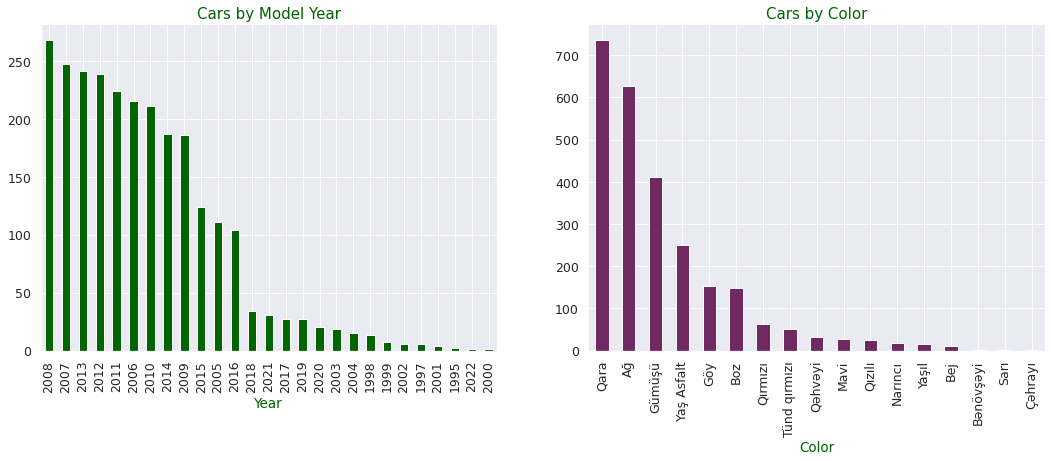

In [303]:
plt.subplot(1,2,1)
df['year'].value_counts().plot(kind = 'bar', figsize = (18,6),fontsize = 12.5,color = '#006400')
plt.xlabel('Year',fontsize = 13.5,color = '#006400')
plt.title('Cars by Model Year',fontsize=15, color = '#006400')
plt.subplot(1,2,2)
df['color'].value_counts().plot(kind = 'bar', figsize = (18,6),fontsize = 12.5,color = '#702963')
plt.xlabel('Color',fontsize = 13.5, color = '#006400')
plt.title('Cars by Color', fontsize=15, color = '#006400')
plt.savefig('cars by model and color')

Model year of most of the cars are `2008`, `2007`, `2013`, `2012` and `2011` 
<br> And color of most of the cars are `'Qara'`, `'Ağ'`, `'Gümüşü'`, `Yaş Asfalt`and `Göy`

Text(0.5, 1.0, 'Most expensive cars')

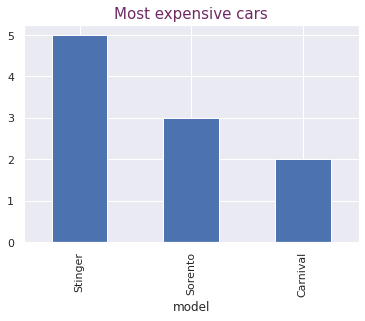

In [304]:
expensive_models = df.sort_values('price(AZN)', ascending = False).head(10)
expensive_models.groupby(['model'])['price(AZN)'].agg('count').sort_values(ascending = False).plot(kind = 'bar')
plt.title('Most expensive cars',fontsize=15, color = '#702963')

Most expensive KIA cars are `Stinger`, `Sorento` and `Carnival`

In [305]:
fig = px.histogram(df, x="price(AZN)", marginal="box", title='Price Distribution of Second Hand Kia Cars in Azerbaijan')
fig.update_layout(yaxis_title = 'Number of cars')
fig.update_layout(xaxis_title = 'Price (AZN)')

# Feature Engineering

### Normalization

**Price Column**

Text(0.5, 1.0, 'Normalized Price Distribution')

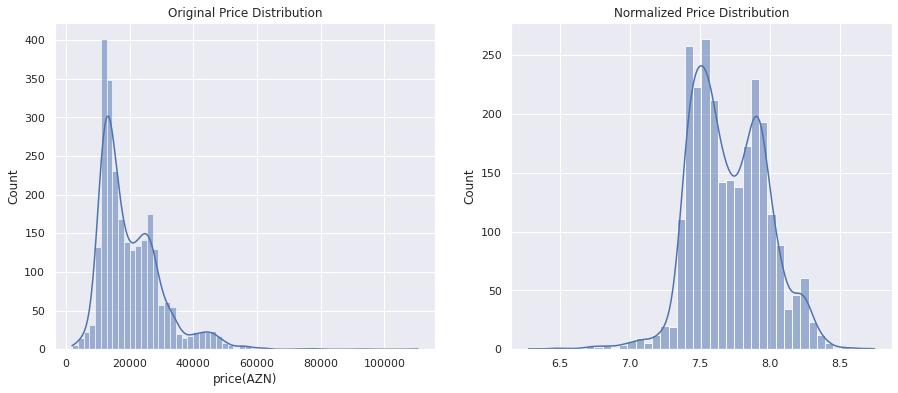

In [306]:
# Let's compare Price distribution before and after
normalized_price = stats.boxcox(df['price(AZN)'].loc[df['price(AZN)'] > 0 ])[0]
fig, ax = plt.subplots(1,2, figsize = (15,6))
sns.histplot(df['price(AZN)'],ax = ax[0], kde = True)
ax[0].set_title('Original Price Distribution')
sns.histplot(normalized_price, ax = ax[1], kde = True)
ax[1].set_title('Normalized Price Distribution')

In [307]:
df['price(AZN)'] = stats.boxcox(df['price(AZN)'])[0]

**Kilometrage Column**

Text(0.5, 1.0, 'Normalized Kilometrage Distribution')

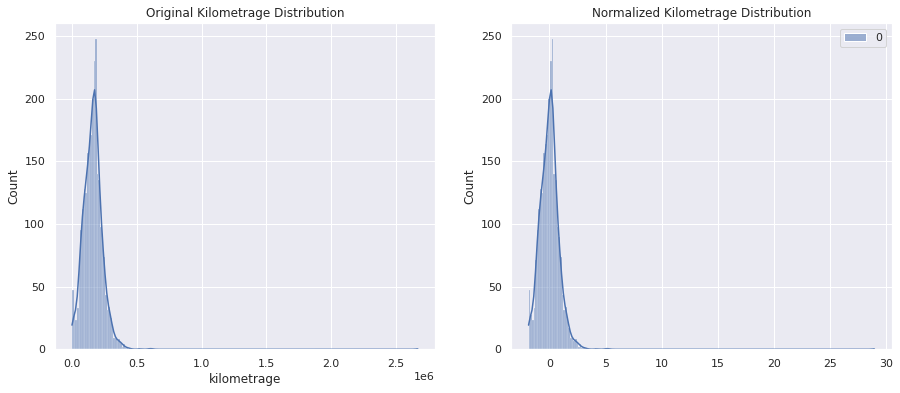

In [308]:
scaling = StandardScaler()
fig, ax = plt.subplots(1,2, figsize = (15,6))
sns.histplot(df['kilometrage'], ax = ax[0], kde = True)
ax[0].set_title('Original Kilometrage Distribution')
sns.histplot(scaling.fit_transform(df[['kilometrage']]), ax = ax[1], kde = True)
ax[1].set_title('Normalized Kilometrage Distribution')

In [309]:
df['kilometrage'] = scaling.fit_transform(df[['kilometrage']])

### Outlier detection

**Price Column**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



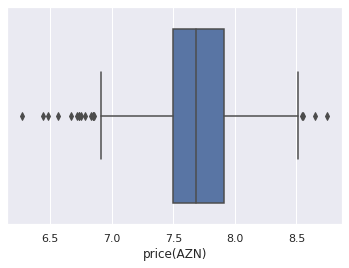

In [310]:
sns.boxplot(df['price(AZN)'])

In [311]:
lower_limit, upper_limit = (df['price(AZN)'].mean() - 2*df['price(AZN)'].std(), df['price(AZN)'].mean() + 2*df['price(AZN)'].std())
df = df[(df['price(AZN)']>lower_limit) & (df['price(AZN)'] < upper_limit)]

**Kilometrage Column**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



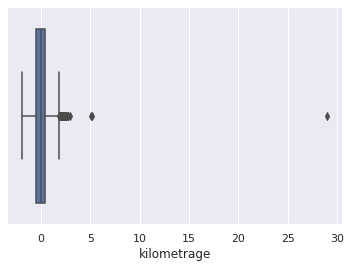

In [312]:
sns.boxplot(df['kilometrage'])

In [313]:
lower_limit2, upper_limit2 = (df['kilometrage'].mean()-2*df['kilometrage'].std(), df['kilometrage'].mean()+2*df['kilometrage'].std())
df = df[(df['kilometrage'] > lower_limit2) & (df['kilometrage'] < upper_limit2)]

### Dimensionality Reduction

In [314]:
object_columns = df.select_dtypes('object').columns
for col in object_columns:
  print('Number of unique values in column',col, df[col].nunique())

Number of unique values in column city 46
Number of unique values in column brand 1
Number of unique values in column model 32
Number of unique values in column color 17
Number of unique values in column body_type 9
Number of unique values in column fuel_type 4
Number of unique values in column transmission 2
Number of unique values in column drivetrain 3
Number of unique values in column new 2


**City column**

In [315]:
city_unique_values = df['city'].value_counts()
city_unique_values

Bakı          1999
Sumqayıt       200
Gəncə           62
Xırdalan        27
Şəmkir          11
Lənkəran         8
Şəki             7
Tovuz            7
Naxçıvan         7
Şirvan           6
Beyləqan         5
Bərdə            5
Şabran           5
Quba             5
Xaçmaz           5
Göyçay           5
Kürdəmir         4
Mingəçevir       4
Masallı          4
Şamaxı           4
İmişli           3
Biləsuvar        3
Göygöl           3
Qəbələ           3
Astara           3
İsmayıllı        3
Cəlilabad        3
Sabirabad        2
Qax              2
Tərtər           2
Salyan           2
Qusar            2
Balakən          2
Neftçala         2
Ağdaş            2
Goranboy         2
Zaqatala         1
Qazax            1
Ağcabədi         1
Ucar             1
Füzuli           1
Cəbrayıl         1
Ağstafa          1
Ağsu             1
Xudat            1
Qobustan         1
Name: city, dtype: int64

In [316]:
city_less_than_10 = city_unique_values[city_unique_values < 8]
df['city'] = df['city'].apply(lambda x: 'Başqa Bölgə' if x in city_less_than_10 else x)

In [317]:
df['city'].nunique()

7

**Color column**

In [318]:
color_unique_values = df['color'].value_counts()
color_unique_values

Qara            703
Ağ              602
Gümüşü          393
Yaş Asfalt      242
Göy             134
Boz             133
Qırmızı          56
Tünd qırmızı     47
Qəhvəyi          29
Mavi             27
Qızılı           20
Narıncı          17
Bej              11
Yaşıl            10
Bənövşəyi         2
Sarı              2
Çəhrayı           1
Name: color, dtype: int64

In [319]:
color_less_than_50 = color_unique_values[color_unique_values< 50]
df['color'] = df['color'].apply(lambda x: 'Başqa rəng' if x in color_less_than_50 else x)

In [320]:
df['color'].nunique()

8

**Model column**

In [321]:
model_unique_values = df['model'].value_counts()
model_unique_values

Rio            646
Optima         460
Sorento        404
Ceed           369
Cerato         187
Sportage       184
Picanto         40
Soul            20
Carens          18
Cadenza         15
Carnival        13
Pride           11
Morning          9
K5               8
Magentis         7
Mohave           5
Rio X-Line       5
Opirus           4
Bongo            4
Cerato Koup      4
Pregio           3
Quoris           3
Ray              1
Spectra          1
K3               1
Niro             1
Sephia           1
Seltos           1
Stinger          1
K2700            1
Venga            1
Stonic           1
Name: model, dtype: int64

In [322]:
models_less_12 =  model_unique_values[model_unique_values < 20]
df['model'] = df['model'].apply(lambda x: 'Başqa Model' if x in models_less_12 else x)

In [323]:
df['model'].nunique()

9

### Categorical data Encoding

In [324]:
body_type = pd.get_dummies(df['body_type'], drop_first = True)
fuel_type = pd.get_dummies(df['fuel_type'], drop_first = True)
transmission = pd.get_dummies(df['transmission'], drop_first = True)
drivetrain = pd.get_dummies(df['drivetrain'], drop_first = True)
city = pd.get_dummies(df['city'], drop_first = True)
color = pd.get_dummies(df['color'], drop_first = True)
model = pd.get_dummies(df['model'], drop_first = True)
df.drop(['body_type', 'fuel_type', 'transmission', 'drivetrain','city', 'color', 'model'], axis = 1, inplace = True)
df = pd.concat([df, body_type,fuel_type,transmission,drivetrain,city,color, model], axis = 1)
df.head()

,year,brand,kilometrage,new,price(AZN),engine(L),engine_power(hp),Hetçbek / Liftbek,Kupe,Mikroavtobus,Minivan,Offroader / SUV,Sedan,Universal,Yük maşını,Dizel,Hibrid,Qaz,Mexaniki,Tam,Ön,Başqa Bölgə,Gəncə,Lənkəran,Sumqayıt,Xırdalan,Şəmkir,Başqa rəng,Boz,Göy,Gümüşü,Qara,Qırmızı,Yaş Asfalt,Ceed,Cerato,Optima,Picanto,Rio,Sorento,Soul,Sportage
0,2008,Kia,0.068767,Xeyr,7.558577,1.6,115,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,2012,Kia,-0.081921,Xeyr,8.053890,2.0,170,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,2015,Kia,-0.739847,Xeyr,8.225252,2.2,197,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,2008,Kia,-0.098958,Xeyr,7.509518,1.4,109,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
4,2013,Kia,-1.145706,Xeyr,8.056573,2.0,184,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


# Splitting data to train and test 

In [325]:
X = df.drop(['brand','new','price(AZN)'], axis = 1)
y = df['price(AZN)']

In [326]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

# Choosing best model

### Linear Regression Model

In [327]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [328]:
# Prediction on test data
test_pred_lin = lin_model.predict(X_test)

In [329]:
accuracy_lr = round(lin_model.score(X_test, y_test),3)
accuracy_lr

0.871

In [330]:
# Let's visualize how close the predicted values to real prices
eval_df = pd.DataFrame({'Actual': y_test, 'Predicted': test_pred_lin})
eval_df.head()

,Actual,Predicted
2156,7.541212,7.521618
2368,7.623273,7.667711
3545,7.752924,7.902874
2033,8.133899,8.122676
894,7.476006,7.443661


In [331]:
print('Accuracy of model:', lin_model.score(X_test, y_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, test_pred_lin)))

Accuracy of model: 0.870974475379381
Root Mean Squared Error: 0.08334955201843691


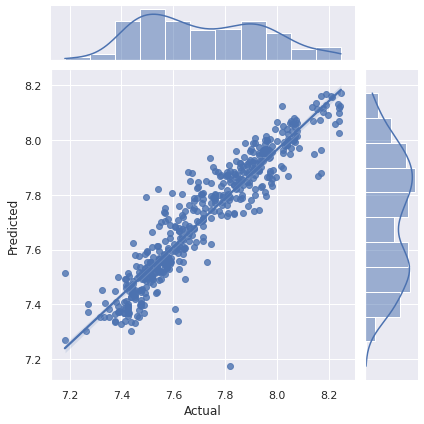

In [332]:
sns.jointplot(x = 'Actual', y = 'Predicted', data = eval_df, kind = 'reg')

In [333]:
# Save the model
import pickle
with open('model_pickle', 'wb') as f:
  pickle.dump(lin_model, f)

In [334]:
with open('model_pickle', 'rb') as f:
  model = pickle.load(f)

### Lasso Regression Model

In [335]:
lasso_model = Lasso()
lasso_model.fit(X_train,y_train)

Lasso()

In [336]:
test_pred_lasso = lasso_model.predict(X_test)

In [337]:
accuracy_lasso = round(lasso_model.score(X_test, y_test),3)
accuracy_lasso

0.403

In [338]:
eval_df = pd.DataFrame({'Actual': y_test, 'Predicted': test_pred_lasso})
eval_df.head()

,Actual,Predicted
2156,7.541212,7.608839
2368,7.623273,7.608839
3545,7.752924,7.778706
2033,8.133899,7.789160
894,7.476006,7.561799


In [339]:
print('Accuracy:',lasso_model.score(X_test, y_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, test_pred_lasso)))

Accuracy: 0.4034380184824595
Root Mean Squared Error: 0.17922279233950353


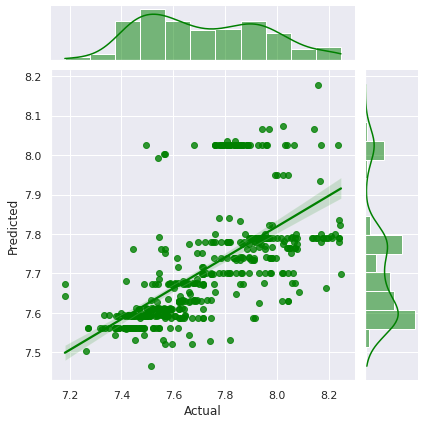

In [340]:
sns.jointplot(x = 'Actual', y = 'Predicted', data = eval_df, kind = 'reg', color = 'green')

### DecisionTreeRegressor

In [341]:
dtr_model = DecisionTreeRegressor()
dtr_model.fit(X_train,y_train)

DecisionTreeRegressor()

In [342]:
test_pred_dtr = dtr_model.predict(X_test)

In [343]:
accuracy_dtr = round(dtr_model.score(X_test, y_test),3)
accuracy_dtr

0.865

In [344]:
eval_df = pd.DataFrame({'Actual': y_test, 'Predicted': test_pred_dtr})
eval_df.head()

,Actual,Predicted
2156,7.541212,7.527839
2368,7.623273,7.619434
3545,7.752924,8.073269
2033,8.133899,8.114951
894,7.476006,7.461034


In [345]:
print('Accuracy:',dtr_model.score(X_test, y_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, test_pred_dtr)))

Accuracy: 0.8652422228208868
Root Mean Squared Error: 0.0851809290480145


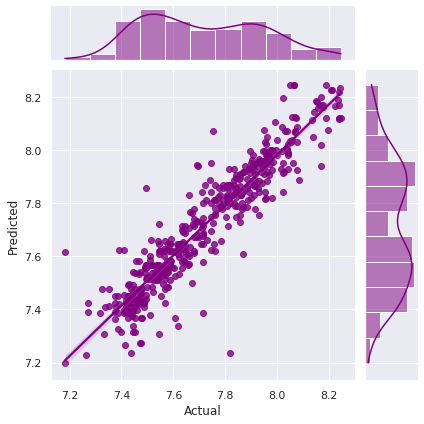

In [346]:
sns.jointplot(x = 'Actual', y = 'Predicted', data = eval_df, kind = 'reg', color = 'purple')

### Comparision

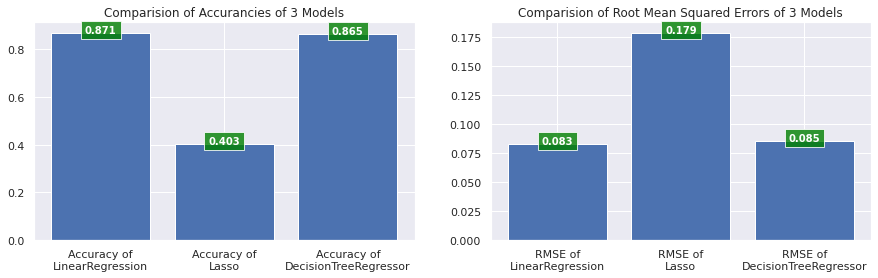

In [348]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center',fontweight='bold',color='white',
                 bbox = dict(facecolor = 'green', alpha =.8))
plt.subplots(figsize=(15,4))
plt.subplot(1,2,1)
x1 = ['Accuracy of\nLinearRegression','Accuracy of\nLasso','Accuracy of\nDecisionTreeRegressor']
y1 = [accuracy_lr,accuracy_lasso,accuracy_dtr]
plt.bar(x1,y1)
plt.title('Comparision of Accurancies of 3 Models')
addlabels(x1,y1)
plt.subplot(1,2,2)
x = ['RMSE of\nLinearRegression','RMSE of\nLasso','RMSE of\nDecisionTreeRegressor']
y = [round(np.sqrt(metrics.mean_squared_error(y_test, test_pred_lin)),3),
     round(np.sqrt(metrics.mean_squared_error(y_test, test_pred_lasso)),3),
     round(np.sqrt(metrics.mean_squared_error(y_test, test_pred_dtr)),3)]
plt.bar(x,y)
plt.title('Comparision of Root Mean Squared Errors of 3 Models')
addlabels(x, y)
plt.savefig('comparision')

As we can see from graph above both in terms of Accuracy and RMSE Linear Regression Model performs better. So we are going to use Linear Regression